<a href="https://colab.research.google.com/github/R4HUL-ROY/Multimodal_feature_extraction/blob/main/ResNet_50_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary modules

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pathlib
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset

In [2]:
data_root = pathlib.Path('/content/drive/MyDrive/Tobacco3482-jpg')

print(data_root)
for item in data_root.iterdir():
  print(item)

/content/drive/MyDrive/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/News
/content/drive/MyDrive/Tobacco3482-jpg/ADVE
/content/drive/MyDrive/Tobacco3482-jpg/Email
/content/drive/MyDrive/Tobacco3482-jpg/Form
/content/drive/MyDrive/Tobacco3482-jpg/Letter
/content/drive/MyDrive/Tobacco3482-jpg/Report
/content/drive/MyDrive/Tobacco3482-jpg/Resume
/content/drive/MyDrive/Tobacco3482-jpg/Scientific
/content/drive/MyDrive/Tobacco3482-jpg/Memo
/content/drive/MyDrive/Tobacco3482-jpg/Note


In [3]:
def get_file_paths_and_labels(data_root):
     img_paths = [str(path) for path in data_root.glob('*/*.jpg')]
     labels = [p.split("/")[-2] for p in img_paths]
     return img_paths, labels

img_paths, labels = get_file_paths_and_labels(data_root)
print(img_paths)
print(labels)
print(len(img_paths))
print(len(labels))

['/content/drive/MyDrive/Tobacco3482-jpg/News/0000023720.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/0000114117.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/0000240416.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/0000162076.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/1002402255-a.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/03754144-b.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/1000150875-a.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/1002402586.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/01138186a.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/03747860.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/03620726.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/01752917.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/0000343395.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/01182899.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/00625137.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/News/04328080.jpg', '/content/drive/

# Create the dataframe

In [4]:
df = pd.DataFrame(list(zip(img_paths, labels)),
               columns =['image_path', 'data_label'])
df.head()

,image_path,data_label
0,/content/drive/MyDrive/Tobacco3482-jpg/News/00...,News
1,/content/drive/MyDrive/Tobacco3482-jpg/News/00...,News
2,/content/drive/MyDrive/Tobacco3482-jpg/News/00...,News
3,/content/drive/MyDrive/Tobacco3482-jpg/News/00...,News
4,/content/drive/MyDrive/Tobacco3482-jpg/News/10...,News


In [5]:
balance=df['data_label'].value_counts()
print (balance)

Memo          620
Email         599
Letter        567
Form          431
Report        265
Scientific    261
ADVE          230
Note          201
News          188
Resume        120
Name: data_label, dtype: int64


# Split the dataframe into train , test and validation

In [6]:
train_df, dummy_df=train_test_split(df, test_size=0.3, shuffle=True, stratify= df["data_label"].values, random_state=0)
test_df, valid_df= train_test_split(dummy_df, test_size=0.5, shuffle=True, stratify= dummy_df["data_label"].values, random_state=0)
print (f"train size: {len(train_df)} test size: {len(test_df)}  valid size: {len(valid_df)}")
length=len(test_df)

train size: 2437 test size: 522  valid size: 523


# Image data generator

In [7]:
batch_size=32
seed_value = 42
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1

trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)

train_gen=trgen.flow_from_dataframe(train_df, x_col='image_path', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=batch_size, shuffle=True, seed=seed_value)

tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)

valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='image_path', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=batch_size, shuffle=False, seed=seed_value)

# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  

test_steps=int(length/test_batch_size)

test_gen=tvgen.flow_from_dataframe(test_df, x_col='image_path', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=test_batch_size, shuffle=False, seed=seed_value)

test_labels=test_gen.labels

Found 2437 validated image filenames belonging to 10 classes.
Found 523 validated image filenames belonging to 10 classes.
Found 522 validated image filenames belonging to 10 classes.


# Transfer learning model creation using ResNet-50 as base model

In [8]:
img_shape=(224,224,3)
class_count = len(set(df['data_label']))
dropout=0.2
lr= 0.001
seed_value = 42


base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=10,
                   weights='imagenet')

base_model.trainable=False

inputs = keras.Input(shape=img_shape)
x = base_model(inputs, training=False)

# x=tf.keras.layers.Dropout(rate=dropout, seed=seed_value)(x)
x =tf.keras.layers.Dense(2048, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=seed_value))(x)
# x=tf.keras.layers.Dropout(rate=dropout, seed=seed_value)(x)
outputs=tf.keras.layers.Dense(class_count, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value))(x)
model=Model(inputs, outputs)

model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 27,804,554
Trainable params: 4,216,842
Non-trainable params: 23,587,712
_________________________________________________________________


# Model Training keeping the base_model as non trainable

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5", verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 

history=model.fit(x=train_gen,  epochs=80, verbose=2, validation_data=valid_gen, callbacks=[checkpoint],
               validation_steps=None,  shuffle=False,  initial_epoch=0)

# history = model.fit(train_gen, validation_data=valid_gen,verbose=2, epochs=20)

Epoch 1/80

Epoch 1: val_loss improved from inf to 2.96803, saving model to /model-001-0.399261-0.434034.h5
77/77 - 1672s - loss: 9.1598 - accuracy: 0.3993 - val_loss: 2.9680 - val_accuracy: 0.4340 - 1672s/epoch - 22s/step
Epoch 2/80

Epoch 2: val_loss improved from 2.96803 to 2.35900, saving model to /model-002-0.465737-0.432122.h5
77/77 - 91s - loss: 2.5818 - accuracy: 0.4657 - val_loss: 2.3590 - val_accuracy: 0.4321 - 91s/epoch - 1s/step
Epoch 3/80

Epoch 3: val_loss improved from 2.35900 to 2.10317, saving model to /model-003-0.493229-0.497132.h5
77/77 - 91s - loss: 2.1988 - accuracy: 0.4932 - val_loss: 2.1032 - val_accuracy: 0.4971 - 91s/epoch - 1s/step
Epoch 4/80

Epoch 4: val_loss improved from 2.10317 to 1.97104, saving model to /model-004-0.513336-0.499044.h5
77/77 - 91s - loss: 2.0158 - accuracy: 0.5133 - val_loss: 1.9710 - val_accuracy: 0.4990 - 91s/epoch - 1s/step
Epoch 5/80

Epoch 5: val_loss improved from 1.97104 to 1.87827, saving model to /model-005-0.530570-0.523901.h5

# Fine Tune model using the base model as trainable

In [11]:
epochs = 80
base_model.trainable=True
fine_tune_epochs= 20
total_epochs=epochs + fine_tune_epochs

model.compile(Adamax(learning_rate=lr/10), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 27,804,554
Trainable params: 27,751,434
Non-trainable params: 53,120
_________________________________________________________________


In [12]:

history_fine = model.fit(x=train_gen,  epochs=total_epochs, verbose=2, validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=epochs)

Epoch 81/100
77/77 - 117s - loss: 2.5915 - accuracy: 0.2840 - val_loss: 1.8712 - val_accuracy: 0.3805 - 117s/epoch - 2s/step
Epoch 82/100
77/77 - 104s - loss: 1.6725 - accuracy: 0.4739 - val_loss: 1.4332 - val_accuracy: 0.5354 - 104s/epoch - 1s/step
Epoch 83/100
77/77 - 108s - loss: 1.3449 - accuracy: 0.6020 - val_loss: 1.3464 - val_accuracy: 0.5889 - 108s/epoch - 1s/step
Epoch 84/100
77/77 - 107s - loss: 1.2279 - accuracy: 0.6327 - val_loss: 1.1840 - val_accuracy: 0.6405 - 107s/epoch - 1s/step
Epoch 85/100
77/77 - 106s - loss: 1.1828 - accuracy: 0.6664 - val_loss: 1.2655 - val_accuracy: 0.6195 - 106s/epoch - 1s/step
Epoch 86/100
77/77 - 105s - loss: 1.0312 - accuracy: 0.7144 - val_loss: 0.9992 - val_accuracy: 0.7247 - 105s/epoch - 1s/step
Epoch 87/100
77/77 - 105s - loss: 0.9332 - accuracy: 0.7526 - val_loss: 0.9189 - val_accuracy: 0.7323 - 105s/epoch - 1s/step
Epoch 88/100
77/77 - 103s - loss: 0.8724 - accuracy: 0.7706 - val_loss: 1.0773 - val_accuracy: 0.6941 - 103s/epoch - 1s/step


# Evaluate the model

In [13]:
model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=True)

18/18 [==============================] - 281s 16s/step - loss: 0.9833 - accuracy: 0.7854


{'accuracy': 0.7854406237602234, 'loss': 0.9833030104637146}

# Plotting the accuracy and loss graph

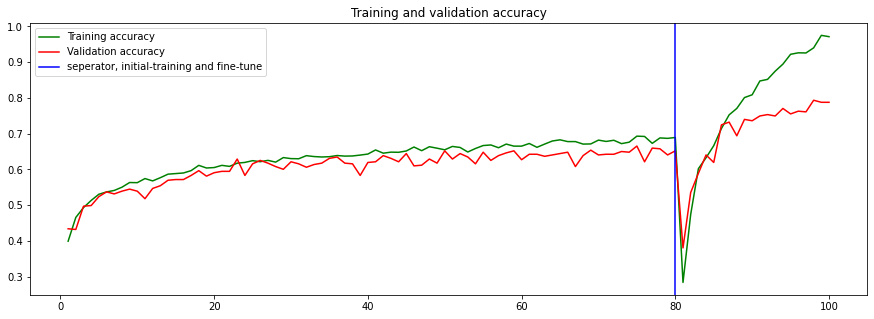

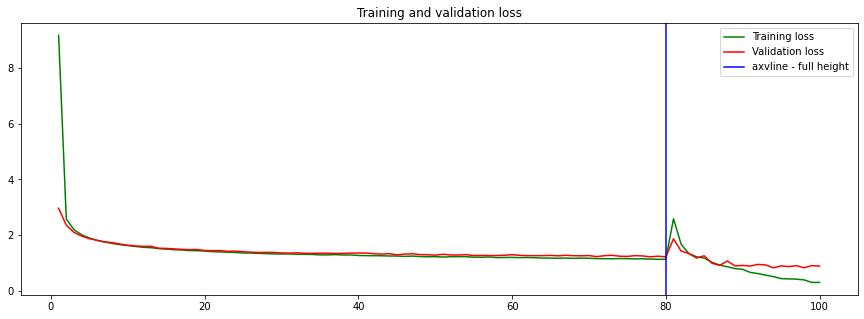

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize = (15, 5))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.axvline(x = 80 , color = 'b', label = 'seperator, initial-training and fine-tune')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize = (15, 5))

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.axvline(x = 80 , color = 'b', label = 'axvline - full height')
plt.title('Training and validation loss')
plt.legend()

plt.show()